In [177]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression as lr
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor as gb
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston

In [178]:
'''
Steps:
1). Simulate confounders
2). Simulate treatment (either correlated or uncorrelated with confounders)
3). Simulate target (either correlated or uncorrelated with confounders)
4). Add treatment effect to target
5). Estimate impact of treatment naively
6). Estimate impact of treatment using Double ML

Notes
--> If LinReg used to estimate propensity and target in DML, yields same treatment effect estimate as LinReg
--> interaction_tgt=False ==> LR does very well at estimating treatment effect (better than DML)
'''

'\nSteps:\n1). Simulate confounders\n2). Simulate treatment (either correlated or uncorrelated with confounders)\n3). Simulate target (either correlated or uncorrelated with confounders)\n4). Add treatment effect to target\n5). Estimate impact of treatment naively\n6). Estimate impact of treatment using Double ML\n\nNotes\n--> If LinReg used to estimate propensity and target in DML, yields same treatment effect estimate as LinReg\n'

In [179]:
confounders = ['money','education','exercise','diet']
tgt_name = 'lifespan'

In [538]:
def gen_treatment(data, treat_corr=True):
        # Correlating
        c_idx = np.random.randint(len(confounders)) # feat which has impact on treatment and target
        print(f'Confounder: {confounders[c_idx]}')
        if treat_corr: 
            conf = data[confounders[c_idx]].values*1.5 
            other = data[confounders[2]].values*0.75 
    #         treat = np.random.rand(len(data),1).reshape(-1,) + conf * other
            treat = 1*np.random.rand(len(data),1).reshape(-1,) + conf # * other
        treat /= conf.sum()
        print(treat.mean())
        return treat
    
def gen_data(n=2000, treat_eff = 0.5, 
             treat_col = 'coffee', 
             treat_corr = True,
             treat_bin = False, 
             conf_corr = True,
             interaction_tgt=True,
             verbose=False):

    #1. 
    if not conf_corr:
        rands=1+np.random.rand(n,len(confounders))*2
        data = pd.DataFrame(rands)

    else:
        if verbose: print('Correlated confounders')
        # The desired mean values of the sample.
        mu = np.array([5.0, 0.0, 10.0, 7.0])

        # The desired covariance matrix.
        r = np.array([
                [  3.40, -2.15, -2.00, 3.00],
                [ -2.15,  5.00,  1.50, -3.00],
                [ -2.00,  1.50,  3.25, -1.20],
                [  3.00, -3.00,  -1.20, 3.90]
            ])

        # Generate the random samples.
        vals = np.random.multivariate_normal(mu, r, size=n)
        data = pd.DataFrame(vals)

    data.columns = confounders

    #2.
    if treat_bin:
        treat = [np.random.randint(2) for _ in range(n)]
    else:
        treat = np.random.rand(n,1).reshape(-1,)
    treat = gen_treatment(treat_corr=True)
    data[treat_col] = treat

    #3.
    other = data[confounders[0]].values*0.5
    conf = data[confounders[c_idx]].values*0.75
    noise = np.random.rand(n,1).reshape(-1,)
    if interaction_tgt:
        tgt = other * conf + noise
    else:
        tgt = other + conf + noise

    #4.
    tgt = tgt + treat_eff*data[treat_col]
    data[tgt_name] = tgt
    return data

In [539]:
'''
Should have a train-test split to learn propensity and tgt models
'''

'\nShould have a train-test split to learn propensity and tgt models\n'

In [659]:
#6. Double-ML

def dml(data, mod='rf', verbose=False):

    # Fitting model to predict tgt from confounders
    if mod=='gb': tgt_mod = gb(max_depth=2, min_samples_leaf=10)
    else: tgt_mod = rfr(max_depth=3, min_samples_leaf=15, n_jobs=-1, n_estimators=50)
    tgt_mod.fit(data[confounders], data[tgt_name])
    # print(tgt_mod.coef_)
    data['tgt_pred'] = tgt_mod.predict(data[confounders])

    # Fitting model to predict propensity (treatment) from confounders
    if mod=='gb': prop_mod = gb(max_depth=2, min_samples_leaf=10)
    else: prop_mod = rfr(max_depth=3, min_samples_leaf=15, n_jobs=-1, n_estimators=50)
    # if treat_bin: prop_mod = rfc()
    prop_mod.fit(data[confounders], data[treat_col])
    data['treat_pred'] = prop_mod.predict(data[confounders])

    # Fitting treatment effect model on tgt and treatment/propensity residuals 
    data['tgt_resid'] = data[tgt_name] - data['tgt_pred']
    data['treat_resid'] = data[treat_col] - data['treat_pred']
    if verbose:
        print(f"Treat Pct Bias: {100*(data['treat_resid']/data[treat_col]).mean()}")
        print(f"Tgt Pct Bias: {100*(data['tgt_resid']/data[tgt_name]).mean()}")
        print(f"Treat MAPE: {100*abs(data['treat_resid']/data[treat_col]).mean()}")
        print(f"Tgt MAPE: {100*abs(data['tgt_resid']/data[tgt_name]).mean()}")

    treat_mod = lr()
    treat_mod.fit(data['treat_resid'].values.reshape(-1,1), data['tgt_resid'])
    print(treat_mod.coef_)
    print(f'Pct Err in DML Treatment Estimation: {100*round((treat_mod.coef_[0] - treat_eff)/treat_eff,4)}')
    return treat_mod.coef_[0]

def fit_naive_model(data):
    # 5a. Fitting naive model
    treat_mod = lr()
    treat_mod.fit(data[treat_col].values.reshape(-1,1), data[tgt_name])
#     print(treat_mod.coef_)
    print(f'Pct Err in Naive Treatment Estimation: {100*round((treat_mod.coef_[0] - treat_eff)/treat_eff,4)}')

def fit_std_model(data):
    # 5b. Fitting standard model
    treat_mod = lr()
    feats = data[[treat_col] + confounders]
    treat_mod.fit(feats, data[tgt_name])
#     print(treat_mod.coef_)
    c = treat_mod.coef_[0]
    print(f'Pct Err in LinReg Treatment Estimation: {100*round((c - treat_eff)/treat_eff,4)}')
    return c

### Generating Distribution of Errors

In [510]:
treat_eff = 0.5
treat_col = 'coffee'
n=2000
mod='gb'
inter_tgt=True
v=True

In [660]:
dml_deltas=[]
std_deltas=[]
for i in range(30):

    data = gen_data(n=n,
                    treat_eff=treat_eff, 
                    treat_col=treat_col,
                    interaction_tgt=inter_tgt,
                    treat_corr=True)
    print(data.describe())

    dml_te = dml(data, mod=mod, verbose=v)
    dml_delta = dml_te - treat_eff
    dml_deltas.append(dml_delta)

    std_te = fit_std_model(data)
    std_delta = std_te - treat_eff
    std_deltas.append(std_delta)

ValueError: Length mismatch: Expected axis has 4 elements, new values have 13 elements

DML MAPE: 2.665079990198779
DML % Bias: 2.665079990198779
DML Stdev of Err: 0.6395463113212005


(array([1., 3., 6., 6., 7., 3., 1., 1., 0., 2.]),
 array([0.26766907, 0.86538763, 1.4631062 , 2.06082477, 2.65854333,
        3.2562619 , 3.85398047, 4.45169903, 5.0494176 , 5.64713617,
        6.24485473]),
 <BarContainer object of 10 artists>)

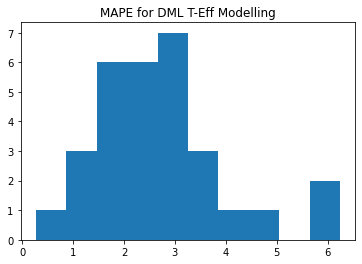

In [427]:
dml_deltas = np.array(dml_deltas)
print(f'DML MAPE: {np.mean(abs(dml_deltas)/treat_eff)}')
print(f'DML % Bias: {np.mean(dml_deltas)/treat_eff}')
print(f'DML Stdev of Err: {np.std(dml_deltas)}')
plt.title('MAPE for DML T-Eff Modelling')
plt.hist(dml_deltas/treat_eff)

Std MAPE: 2.2868378298204273
Std % Bias: -0.1621817301910489
Std Stdev of Err: 1.3770679712041356


(array([2., 0., 2., 1., 9., 3., 3., 6., 2., 2.]),
 array([-6.77700168, -5.58652592, -4.39605017, -3.20557441, -2.01509866,
        -0.82462291,  0.36585285,  1.5563286 ,  2.74680436,  3.93728011,
         5.12775587]),
 <BarContainer object of 10 artists>)

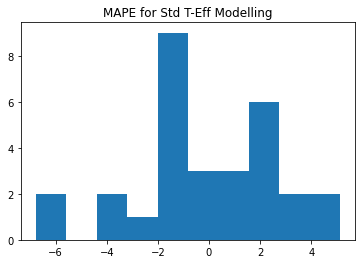

In [428]:
std_deltas = np.array(std_deltas)
print(f'Std MAPE: {np.mean(abs(std_deltas)/treat_eff)}')
print(f'Std % Bias: {np.mean(std_deltas/treat_eff)}')
print(f'Std Stdev of Err: {np.std(std_deltas)}')
plt.title('MAPE for Std T-Eff Modelling')
plt.hist(std_deltas/treat_eff)

### Boston Housing Dataset

In [718]:
def gen_boston(treat_imp=0.15):
    data = load_boston()
    X = data['data']
    y = data['target']
    data = pd.DataFrame(X)
    data[treat_col] = gen_treatment(data)
    
    # Sizing treatment effect
#     treat_eff = y.mean() * treat_imp # DML works well like this
    treat_eff = treat_imp*y.mean()/data[treat_col].mean()

    data[tgt_name] = y + data[treat_col]*treat_eff
    print(f'Treatment Effect: {treat_eff}')
    return data, treat_eff

def gen_treatment(data, treat_corr=True):
    # Correlating
    c_idx = np.random.randint(len(confounders)) # feat which has impact on treatment and target
    if c_idx == 9: c_idx = 5 # error is super super high for 9, maybe worth seeing why
    print(f'Confounder: {confounders[c_idx]}')
    if treat_corr: 
        conf = data[confounders[c_idx]].values*1.5 
        other = data[confounders[2]].values*0.75 
#         treat = np.random.rand(len(data))*other + conf # harder - treatment is more confounded (two features)
#         treat = np.random.rand(len(data))*conf + conf # easier
#         treat = np.random.rand(len(data))*conf.mean() + conf # easier - more indep influence via more noise
#         treat = np.random.rand(len(data)) + conf # hardddd - why? limited independent influence
        treat = conf # hardest by far - why? Treat has no independent influence over tgt, all controlled by conf
    print(f'Mean treament: {treat.mean()}')
    return treat

def smape(pred, act):
    return 2*abs(pred-act)/(abs(pred) + abs(act))

In [719]:
dml_errs=[]
dml_smapes=[]
std_errs=[]
std_smapes=[]
for i in range(30):
    data, treat_eff = gen_boston()

    dml_te = dml(data, mod=mod, verbose=True)
    dml_smape = smape(dml_te,treat_eff)
    print(f'DML SMAPE: {dml_smape}')
    dml_errs.append( (dml_te - treat_eff) / treat_eff)
    dml_smapes.append(dml_smape)

    std_te = fit_std_model(data)
    std_smape = smape(std_te,treat_eff)
    std_errs.append( (std_te - treat_eff)/treat_eff )
    std_smapes.append(std_smape)

Confounder: 12
Mean treament: 18.97959486166008
Treatment Effect: 0.17808182805019956
Treat Pct Bias: -0.2930241077875277
Tgt Pct Bias: -1.2186396459744036
Treat MAPE: 1.233885271546418
Tgt MAPE: 7.232871056376355
[0.06120468]
Pct Err in DML Treatment Estimation: -65.63
DML SMAPE: 0.9768804321947941
Pct Err in LinReg Treatment Estimation: -166.76999999999998
Confounder: 11
Mean treament: 535.01104743083
Treatment Effect: 0.006317478797582365
Treat Pct Bias: -3.662219782000889
Tgt Pct Bias: -1.4211958812910737
Treat MAPE: 4.438445236078113
Tgt MAPE: 7.461108390870168
[-0.0622465]
Pct Err in DML Treatment Estimation: -1085.31
DML SMAPE: 2.0
Pct Err in LinReg Treatment Estimation: -8691627210452542.0
Confounder: 11
Mean treament: 535.01104743083
Treatment Effect: 0.006317478797582365
Treat Pct Bias: -3.662219782000889
Tgt Pct Bias: -1.4211958812910737
Treat MAPE: 4.438445236078113
Tgt MAPE: 7.461108390870168
[-0.0622465]
Pct Err in DML Treatment Estimation: -1085.31
DML SMAPE: 2.0
Pct Err

Treat Pct Bias: -0.003186721035679778
Tgt Pct Bias: -1.3280268146220962
Treat MAPE: 0.09839016591553529
Tgt MAPE: 7.430838368200917
[-106.40837852]
Pct Err in DML Treatment Estimation: -2719.48
DML SMAPE: 2.0
Pct Err in LinReg Treatment Estimation: -232.63
Confounder: 6
Mean treament: 102.86235177865612
Treatment Effect: 0.032858678517186435
Treat Pct Bias: -0.2077556084318087
Tgt Pct Bias: -1.2595539314922506
Treat MAPE: 0.8542192332417708
Tgt MAPE: 7.220881805947263
[0.11206346]
Pct Err in DML Treatment Estimation: 241.04999999999998
DML SMAPE: 1.0930667162507852
Pct Err in LinReg Treatment Estimation: -29.799999999999997
Confounder: 6
Mean treament: 102.86235177865612
Treatment Effect: 0.032858678517186435
Treat Pct Bias: -0.2077556084318087
Tgt Pct Bias: -1.2595539314922506
Treat MAPE: 0.8542192332417708
Tgt MAPE: 7.220881805947263
[0.11206346]
Pct Err in DML Treatment Estimation: 241.04999999999998
DML SMAPE: 1.0930667162507852
Pct Err in LinReg Treatment Estimation: -29.799999999

DML MAPE: 1.4156802125489005
DML % Bias: 57.85088693019637
DML Stdev of Err: 158.18800920979885


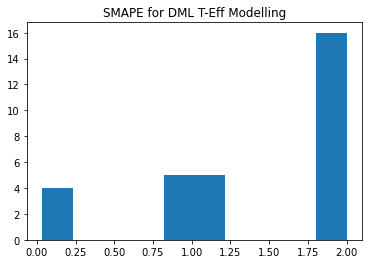

(array([26.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.]),
 array([-27.19478505,  21.60821133,  70.41120772, 119.21420411,
        168.0172005 , 216.82019688, 265.62319327, 314.42618966,
        363.22918604, 412.03218243, 460.83517882]),
 <BarContainer object of 10 artists>)

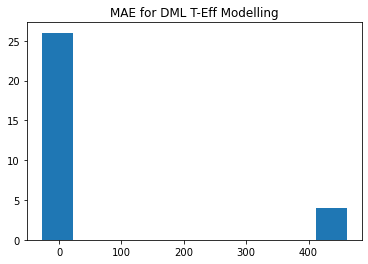

In [720]:
dml_errs = np.array(dml_errs)
dml_smapes = np.array(dml_smapes)
print(f'DML MAPE: {np.mean(dml_smapes)}')
print(f'DML % Bias: {np.mean(dml_errs)}')
print(f'DML Stdev of Err: {np.std(dml_errs)}')
plt.title('SMAPE for DML T-Eff Modelling')
plt.hist(dml_smapes)
plt.show()
plt.title('MAE for DML T-Eff Modelling')
plt.hist(dml_errs)

std MAPE: 1.1627752321498266
std % Bias: -11588836280603.729
std Stdev of Err: 29545851167314.223


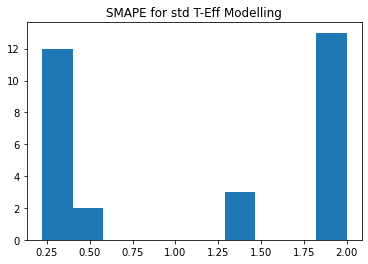

(array([ 4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 26.]),
 array([-8.69162721e+13, -7.82246449e+13, -6.95330177e+13, -6.08413905e+13,
        -5.21497633e+13, -4.34581361e+13, -3.47665088e+13, -2.60748816e+13,
        -1.73832544e+13, -8.69162721e+12,  4.59666657e+00]),
 <BarContainer object of 10 artists>)

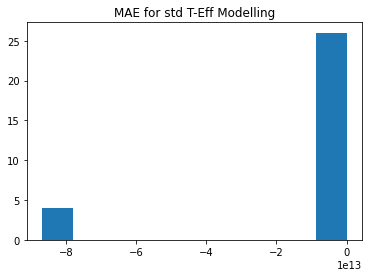

In [721]:
std_errs = np.array(std_errs)
std_smapes = np.array(std_smapes)
print(f'std MAPE: {np.mean(std_smapes)}')
print(f'std % Bias: {np.mean(std_errs)}')
print(f'std Stdev of Err: {np.std(std_errs)}')
plt.title('SMAPE for std T-Eff Modelling')
plt.hist(std_smapes)
plt.show()
plt.title('MAE for std T-Eff Modelling')
plt.hist(std_errs)

In [559]:
std_deltas

array([  17.31980241,  -12.1452623 , -104.48126999,   43.96499267,
         53.08141902,    7.73572938,  -50.48000266,   20.81700467,
         52.98385207,  -25.70494096,   -3.70890727,   60.78354789,
        -18.63243223,  -10.21703738,   82.90286475,  -39.27470829,
         75.15649121,  -61.62567327,   -9.77963133,  -26.84579454,
         84.43843978, -144.30857213,   25.74841687,   80.66153854,
         29.42890267,   40.18517415,   23.6328549 ,   39.79196179,
         -4.79805458,   16.27760163])

In [560]:
treat_eff

24.98191680129445